# Additional analysis for Version 3 - H2O dilution series.


In [121]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list

sys.path.append("/Users/lish/li.github/consensus_serum_metabolome/utils")
from mining import * 

In [25]:
# Not samea as default khipu.utils; will be merged later
isotope_search_patterns = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%, but Ca is not common in metabolites
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), (67.987424, 'NaCOOH'),
                            (82.0030, 'C2HF3'),
                            (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]

# Khipu has two-stage adduct search: first a small set of common adducts, then an extended set
# We treat neutral loss (ISFs) ad hoc here, as a post-processing step after khipu

extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'MeOH'),
                            (-35.037114, '-NH3-H2O'), # not incuded in candidates below
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

candidate_fragments = '''14.0155	792	14.0155	['14.01565', "± CH2, alkane chains, waxes, fatty acids, methylation; or '-[C3H6ON] <-> -[C2H4ON], acrylamide versus iodoacetamide in cysteine alkylation (gels)", "{'C': 1, 'H': 2}"]
18.0104	780	18.0104	['-18.010565', 'H2O', "{'H': -2, 'O': -1}"]
2.0156	634	2.0156	['2.01565', '± 2H, opening or forming of double bond', "{'H': 2}"]
28.0312	550	28.0312	['28.0313', '± C2H4, natural alkane chains such as fatty acids', "{'C': 2, 'H': 4}"]
15.9948	420	15.9948	['15.99492', '± O, e.g. oxidation/reduction', "{'O': 1}"]
17.0264	404	17.0264	['-17.026549', 'NH3', "{'N': -1, 'H': -3}"]
26.0155	392	26.0155	[' C2H2']
27.9948	385	27.9948	['27.99492', '± CO', "{'C': 1, 'O': 1}"]
32.026	311	32.0261	['32.026215', 'MeOH', "{'C': 1, 'H': 4, 'O': 1}"]
42.0104	301	42.0104	['42.01057', '± COCH2', "{'C': 2, 'O': 1, 'H': 2}"]
67.9872	295	67.9873	['67.987424', 'NaCOOH', "{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"]
13.9791	287	13.9791	['13.97927', 'O <-> 2H, e.g. Oxidation follwed by H2O elimination', "{'H': -2, 'O': 1}"]
42.0468	278	42.0468	['42.04695', '± C3H6, propylation', "{'C': 3, 'H': 6}"]
46.0053	277	46.0053	['-46.005479', 'H2O+CO', "{'C': -1, 'H': -2, 'O': -2}"]
'''
candidate_fragments = [
    (float(x.split()[0]), x) for x in candidate_fragments.splitlines()
]
isf_candidate_fragments = [x[0] for x in candidate_fragments]

In [3]:
def get_features_in_rtwindow(list_features, rt_ref, rt_stdev):
    '''
    returns features in list_features that are within rt_stdev
    '''
    return [f for f in list_features if abs(f['rtime']-rt_ref) <= rt_stdev]   

def get_khipus_in_rtwindow(list_khipus, rt_ref, rt_stdev):
    '''
    returns features in list_features that are within rt_stdev
    '''
    return [f for f in list_khipus if abs(f['MS1_pseudo_Spectra'][0]['rtime']-rt_ref) <= rt_stdev]  

def mz_in_list(mz, mlist, max_diff=0.0005, ppm=5):
    '''
    Only considering positive mz values.
    mz can be zero, which is False match.
    '''
    r = False
    if mz > max_diff:
        deltas = sorted([abs(x-mz) for x in mlist])
        if deltas[0] <= max_diff or deltas[0]/mz < ppm*1e-6:
            r = True
    return r 
    
def explain_a_dataset(list_khipus, remaining_features, isf_candidate_fragments, rt_stdev=0.613):
    '''
    list_khipus : sorted by descending mass.
    
    Khipus and other features explained by isf_candidate_fragments.
    Record explained khipus, features, [(delta_mz, id, delta_rt)]
    '''
    explained_khipu_ids, explained_feature_ids = [], []
    delta_values_used = []
    
    for ii in range(len(list_khipus)-1):
        _m0 = get_M0(list_khipus[ii]['MS1_pseudo_Spectra'])
        rt_ref = _m0['rtime']
        base_mz = _m0['mz']
        khipus_in_rtwindow = get_khipus_in_rtwindow(
            list_khipus[ii+1:], 
            rt_ref, 
            rt_stdev)
        for k in khipus_in_rtwindow:
            _d = list_khipus[ii]['neutral_formula_mass']-k['neutral_formula_mass']
            if mz_in_list(_d, isf_candidate_fragments):  # Only considering positive mz values.
                explained_khipu_ids.append(k['interim_id'])
                delta_values_used.append(
                    (_d, k['interim_id'], rt_ref-get_M0(k['MS1_pseudo_Spectra'])['rtime']))
            
        features_in_rtwindow = get_features_in_rtwindow(
            remaining_features, 
            rt_ref, 
            rt_stdev)
        for f in features_in_rtwindow:
            _d = base_mz - f['mz']
            if mz_in_list(
                _d, isf_candidate_fragments
            ):
                explained_feature_ids.append(f['id'])
                delta_values_used.append(
                    (_d, f['id'], rt_ref-f['rtime']))
                
    return explained_khipu_ids, explained_feature_ids, delta_values_used


In [2]:
!ls

BM21 alias
H2O-Seq_001.csv
Qstd_H2O_MS1_mzml
V8-Seq_001.csv
dilutions.ipynb
hilicpos
rBM21H2O_hilicpos_asari_project_101101720
rBM21H2O_rpneg_asari_project_101101855
rpneg
unused_mzml


In [4]:
files = [
    'rBM21H2O_hilicpos_asari_project_101101720/export/full_Feature_table.tsv', 
    'rBM21H2O_rpneg_asari_project_101101855/export/full_Feature_table.tsv',
]

In [26]:
_n, list_features = read_features_from_asari_table(
        open(files[0]).read()
        )
for f in list_features:
        f['representative_intensity'] = f['peak_area']
list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                        list_features, 
                        isotope_search_patterns=isotope_search_patterns, 
                        adduct_search_patterns=adduct_search_patterns_pos,
                        extended_adducts=extended_adducts, 
                        mz_tolerance_ppm=5,
                        rt_tolerance=1,
                        mode='pos',
                        charges=[1, 2, 3],
                        )

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', 'MT_20211020_071', 'Blank_20211020_001', 'Blank_20211020_003', 'Blank_20211020_005', 'Blank_std_20211020_1_001', 'MT_20211020_001', 'MT_20211020_003', 'MT_20211020_009', 'MT_20211020_011']
Read 6850 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M+H+       Na/H        K/H        ACN     NaCOOH
M0         1.007276  22.989216  38.963158  42.033825  68.994700
13C/12C    2.010631  23.992571  39.966513  43.037180  69.998055
37Cl/35Cl  3.004276  24.986216  40.960158  44.030825  70.991700
13C/12C*2  3.013986  24.995926  40.969868  44.040535  71.001410
13C/12C*3  4.017341  25.999281  41.973223  45.043890  72.004765
Constructed 1093 khipus in this round.


Khipu search grid: 
                       M+H+, 2x charged  Na/H, 2x charged  K/H, 2x charged  \
M0   

In [6]:
list_features[88]

{'id_number': 'F89',
 'id': 'F89',
 'mz': 70.0662,
 'rtime': 128.56,
 'apex': 128.56,
 'left_base': 125.92,
 'right_base': 128.99,
 'parent_masstrack_id': '41',
 'peak_area': 1579710.0,
 'cSelectivity': 0.85,
 'goodness_fitting': 0.8,
 'snr': 6.0,
 'detection_counts': 18,
 'representative_intensity': 1579710.0}

In [27]:
_n, len(list_khipus), len(all_assigned_fids)

(42, 1141, 3121)

In [28]:
list_khipus[220].print3()

,M+H+
M0,193.1699
13C/12C*3,196.1808


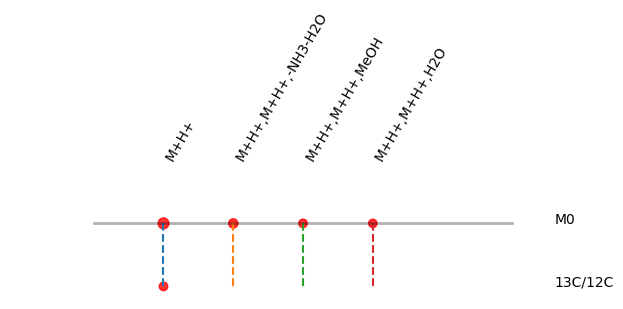

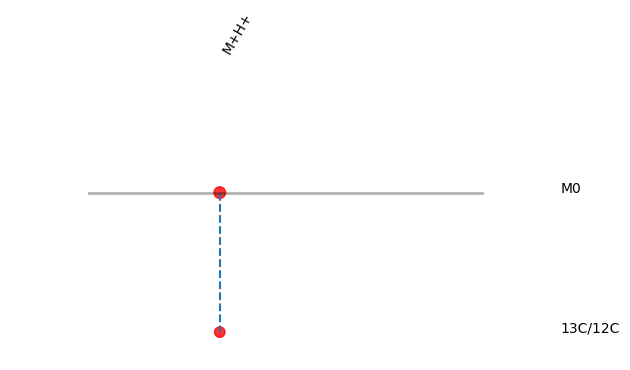

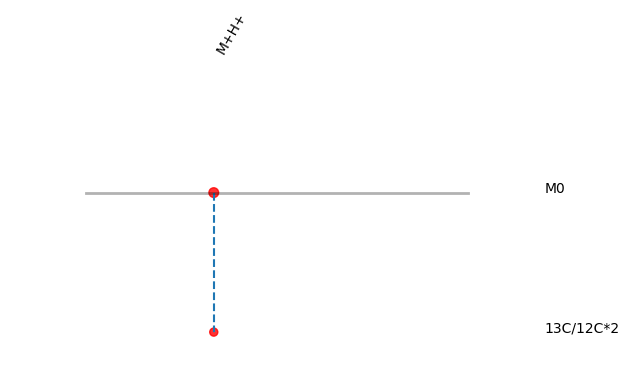

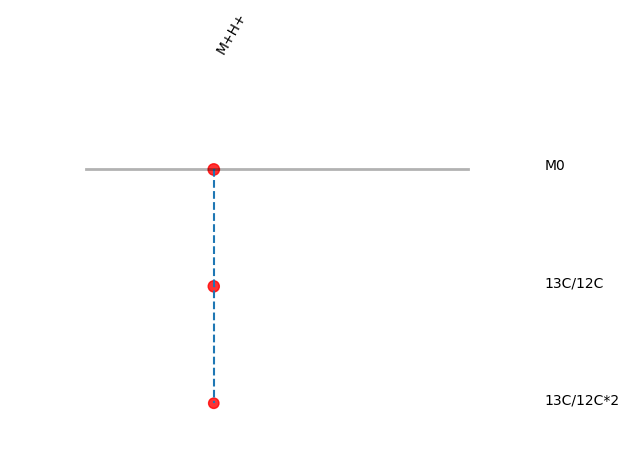

In [31]:
# 
for kp in list_khipus[724:728]:
    kp.plot_khipu_diagram()

In [32]:
list_khipus[724].print()

          M+H+ M+H+,-NH3-H2O M+H+,MeOH M+H+,H2O
M0       F5745         F4540     F5583    F5231
13C/12C  F5758                                 


In [34]:
kp.nodes_to_use

{'F5752', 'F5786', 'F5794'}

In [35]:
len(list_khipus), len([kp for kp in list_khipus if len(kp.nodes_to_use)>2])

(1141, 308)

In [40]:
# make fid to khipu map
fid2khipu = {}
for kp in list_khipus:
    for f in kp.nodes_to_use:
        fid2khipu[f] = kp

In [41]:
# 
featureDict = {}
for f in list_features: featureDict[f['id']] = f

## Select khipus to use based on annotation

M+H+ or M-H-, has lib match 

In [ ]:
# feature_id	feature_mz	feature_rtime	csm_name	csm_ion_relation	csm_empCpd_id	lib_matches
anno = [
    'combined_annotation_hilicpos.tsv',
    'combined_annotation_rpneg.tsv',
]
primary = ['M0,M+H+', 'M0,M-H-']

In [39]:
posFIDs = []
for line in open(anno[0]):
    if line.startswith('feature_id'):
        continue
    fid, mz, rt, name, ion_relation, empCpd_id, lib_matches = line.split('\t')
    if lib_matches.strip() and ion_relation in primary:
        posFIDs.append(fid)
len(posFIDs), posFIDs[:5]

(44, ['F722', 'F1330', 'F862', 'F1151', 'F1282'])

In [64]:
sel_posFIDs = [f for f in posFIDs if f in fid2khipu and len(fid2khipu[f].nodes_to_use) > 2]
len(sel_posFIDs), sel_posFIDs[:5]

(16, ['F862', 'F1891', 'F147', 'F459', 'F1702'])

F862 95.049 137.12


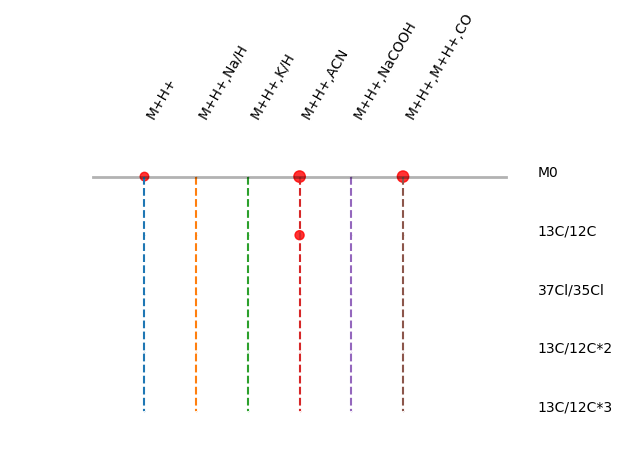

F1891 114.066 74.93


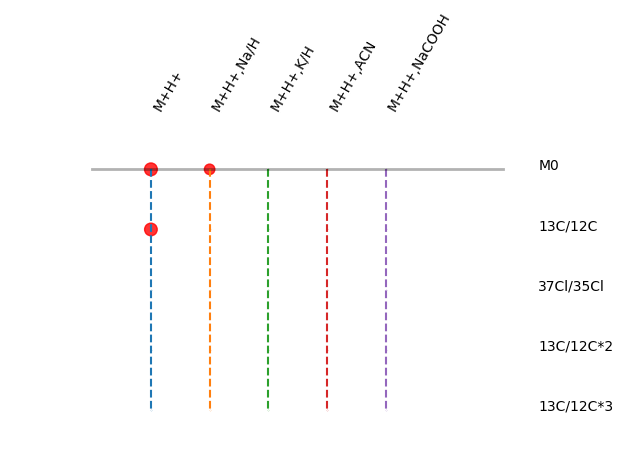

F147 118.0862 142.15


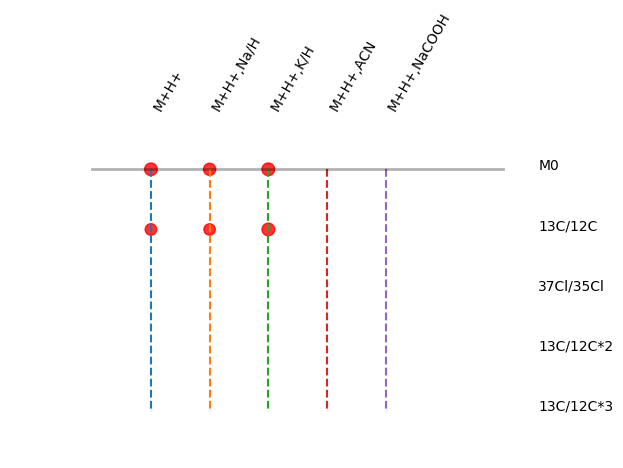

F459 126.0218 143.25


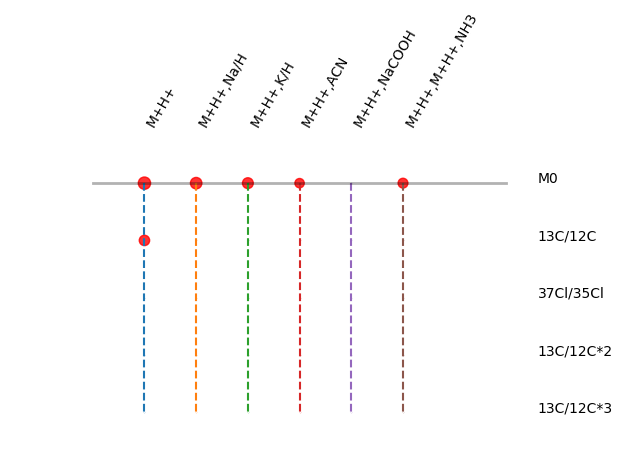

F1702 138.0549 143.25


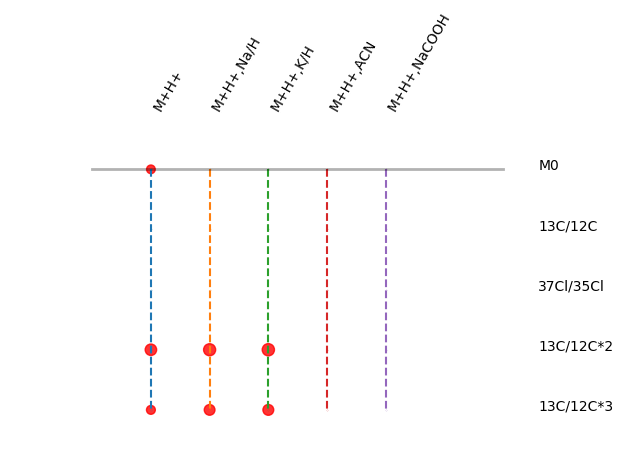

F1446 162.1123 184.69


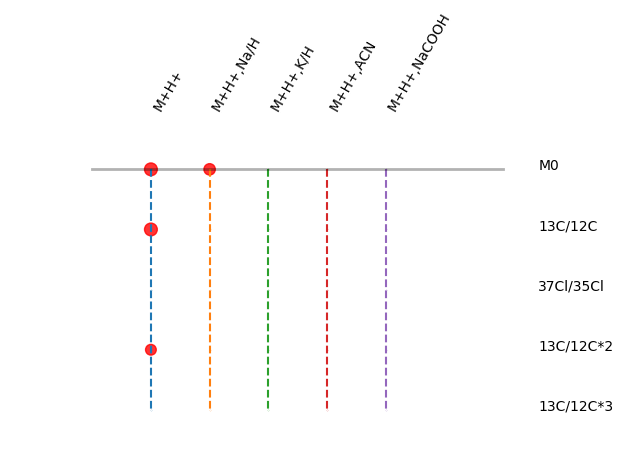

F1751 166.0861 114.3


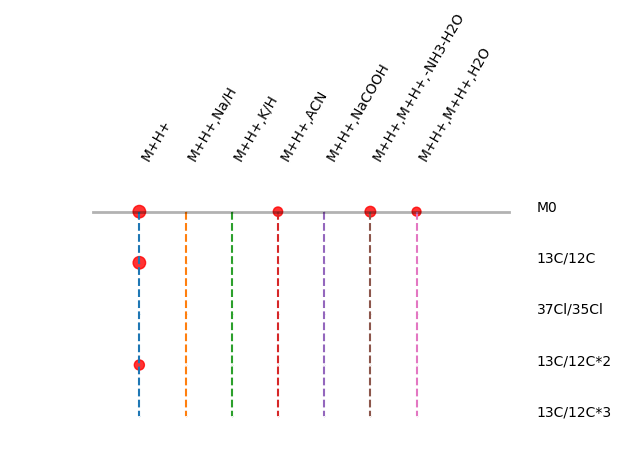

F2253 195.0876 16.97


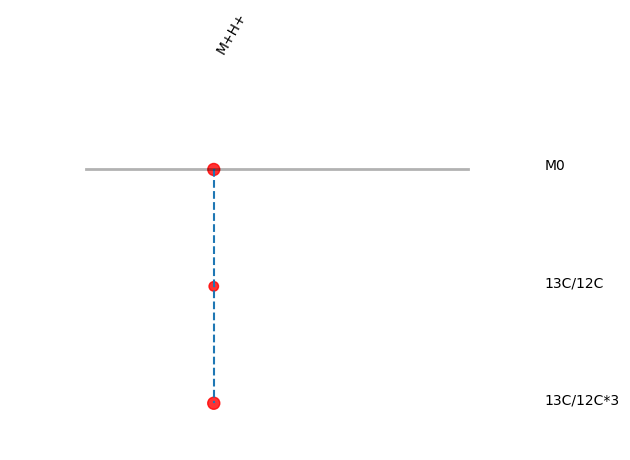

F3441 204.1229 160.8


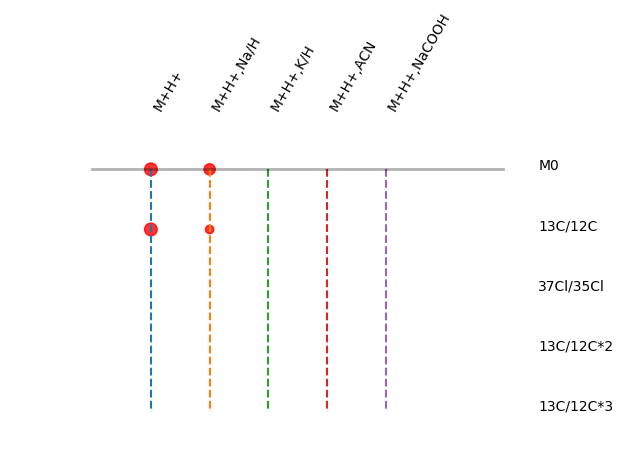

F3024 258.11 196.72


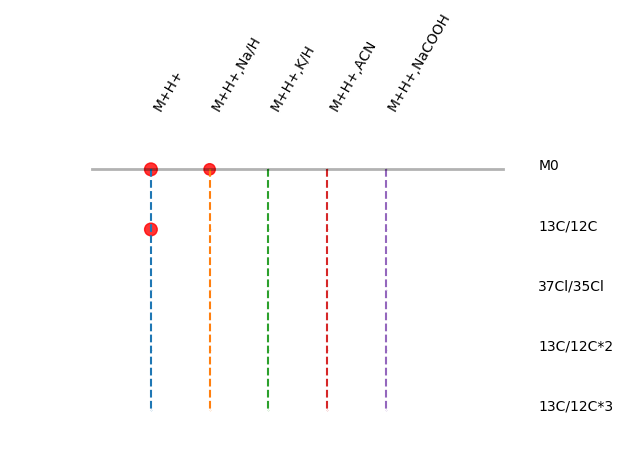

F3312 265.1182 104.97


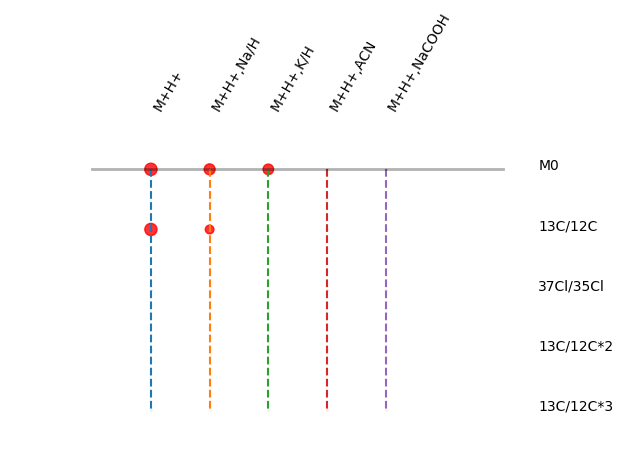

F2728 286.1437 15.44


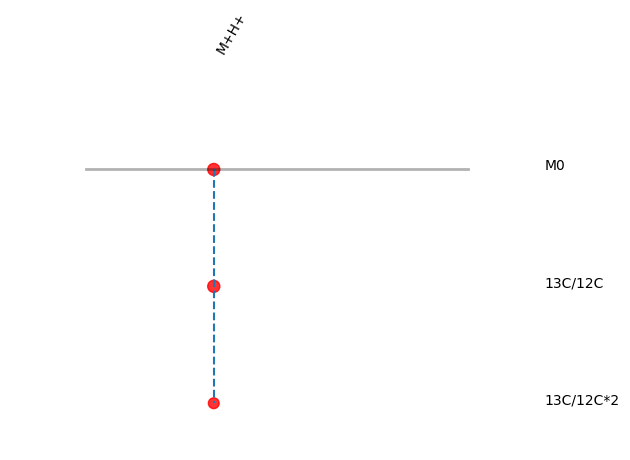

F3433 301.2162 15.22


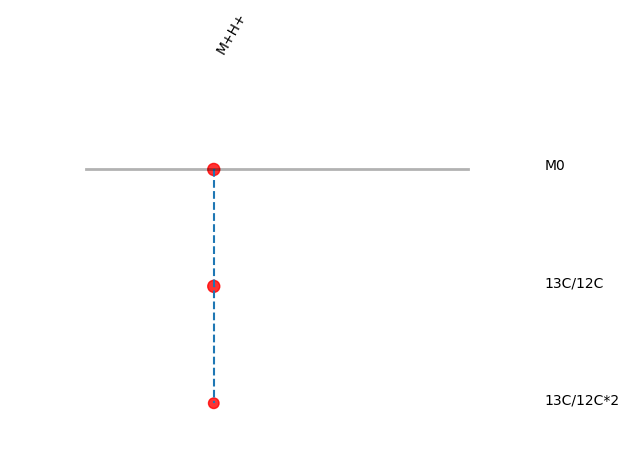

F4828 341.2111 15.44


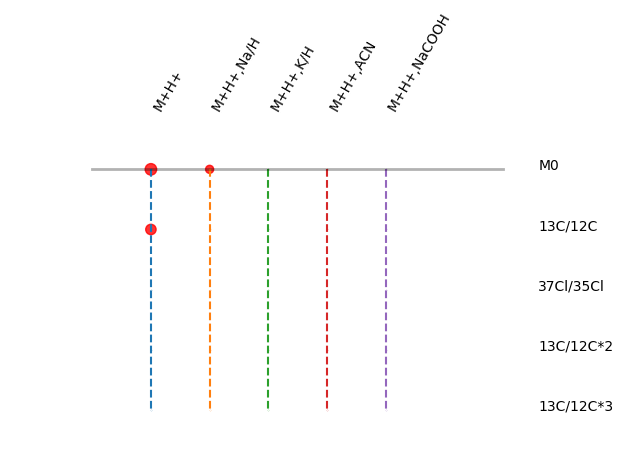

F3947 346.1221 17.85


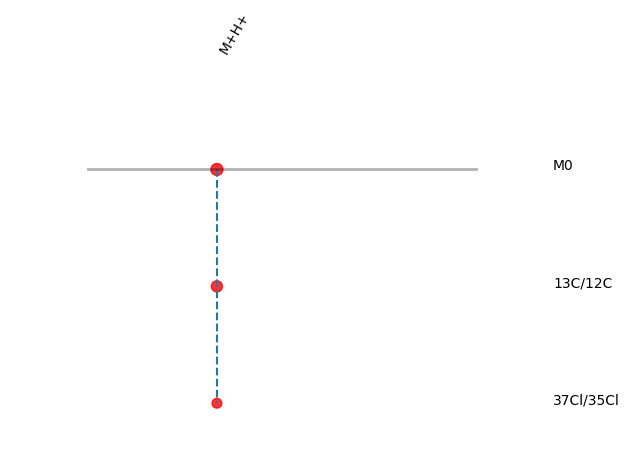

F5878 496.3399 91.38


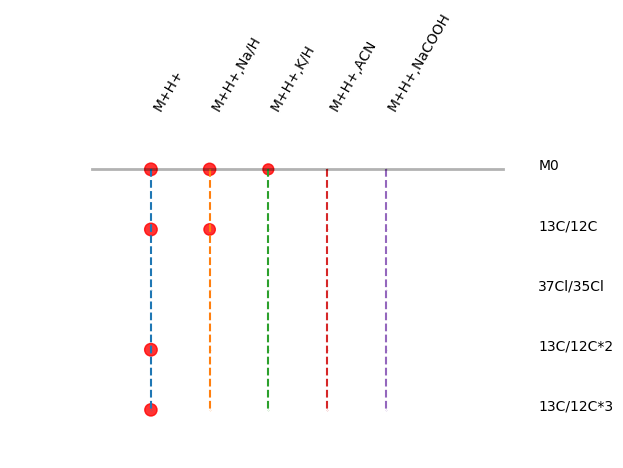

In [46]:
for f in sel_posFIDs:
    print(f, featureDict[f]['mz'], featureDict[f]['rtime'])
    kp = fid2khipu[f]
    kp.plot_khipu_diagram()

In [51]:
fid2khipu['F459'].print()

           M+H+  Na/H    K/H  ACN NaCOOH M+H+,NH3
M0         F459  F145  F1565  F25           F2018
13C/12C    F552                                  
37Cl/35Cl                                        
13C/12C*2                                        
13C/12C*3                                        


In [55]:
fid2khipu['F459'].feature_map #, fid2khipu['F459'].feature_dict

{'F25': ('M0', 'ACN'),
 'F1565': ('M0', 'K/H'),
 'F459': ('M0', 'M+H+'),
 'F552': ('13C/12C', 'M+H+'),
 'F145': ('M0', 'Na/H'),
 'F2018': ('M0', 'M+H+,NH3')}

**Note**
A few errors seen. 
Pop F1702. 

Without M1, M2 should be wrong. 
Limit plots to [M+H+  Na/H    K/H  ACN] * [M0, 13C/12C, 13C/12C*2] 

Use intensity from samples not combined peak areas. 

In [65]:
sel_posFIDs = [x for x in sel_posFIDs if x != 'F1702']

Text(0, 0.5, 'm/z')

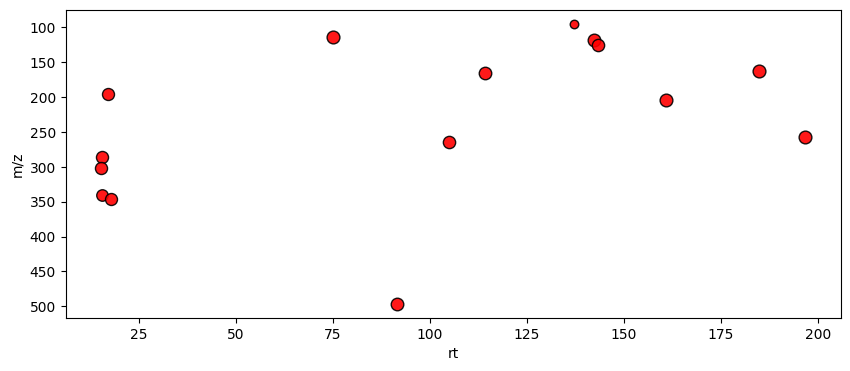

In [71]:
# prototype
fig, ax = plt.subplots(figsize=(10,4))
for f in sel_posFIDs:
    rt = featureDict[f]['rtime']
    mz = featureDict[f]['mz']
    intensity = featureDict[f]['representative_intensity']
    ax.plot(rt, mz, markersize=np.log10(intensity+1), marker='o', color='r', markeredgecolor='k', alpha=0.9)
ax.set_xlabel('rt')
ax.invert_yaxis()
ax.set_ylabel('m/z')


In [132]:
[(f, featureDict[f]['rtime'], fid2khipu[f]) for f in sel_posFIDs]

[('F862', 137.12, <khipu.model.Khipu at 0x346361310>),
 ('F1891', 74.93, <khipu.model.Khipu at 0x346ac0190>),
 ('F147', 142.15, <khipu.model.Khipu at 0x3444b65d0>),
 ('F459', 143.25, <khipu.model.Khipu at 0x34444ae50>),
 ('F1446', 184.69, <khipu.model.Khipu at 0x3426c0310>),
 ('F1751', 114.3, <khipu.model.Khipu at 0x3461a7d50>),
 ('F2253', 16.97, <khipu.model.Khipu at 0x346ada190>),
 ('F3441', 160.8, <khipu.model.Khipu at 0x3461b13d0>),
 ('F3024', 196.72, <khipu.model.Khipu at 0x3461b10d0>),
 ('F3312', 104.97, <khipu.model.Khipu at 0x3461d1f90>),
 ('F2728', 15.44, <khipu.model.Khipu at 0x3461e34d0>),
 ('F3433', 15.22, <khipu.model.Khipu at 0x3469ce710>),
 ('F4828', 15.44, <khipu.model.Khipu at 0x346b53510>),
 ('F3947', 17.85, <khipu.model.Khipu at 0x346978bd0>),
 ('F5878', 91.38, <khipu.model.Khipu at 0x346bdf650>)]

In [126]:
# from inspection above
unwanted = ['F1702', 'F3433', 'F2728', 'F3947', 'F862', 'F147', 'F2728',] # 'F459', 
sample_1024 = 'MT_20211020_011'
sample_64 = 'MT_20211020_025'
sample_qstd = 'MT_20211020_079'

fdata = pd.read_csv(files[0], sep='\t', usecols=['id_number', sample_1024, sample_64, sample_qstd], index_col='id_number')

In [77]:
fdata[sample_1024]['F147']

4726757

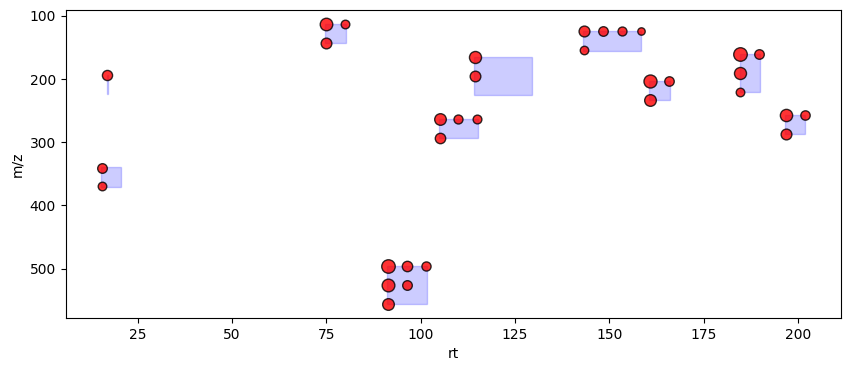

In [160]:
def sz(x):
    return np.log10(x+1)
iso_shift = {'M0': 0, '13C/12C': 30, '13C/12C*2': 60}
adduct_shift = {'M+H+': 0, 'Na/H': 5, 'K/H': 10, 'ACN': 15}

dict_rect = {}
# do high concentration first
fig, ax = plt.subplots(figsize=(10,4))
for f in sel_posFIDs:
    if f not in unwanted:
        all_rts = []
        all_mzs = []
        for k,v in fid2khipu[f].feature_map.items(): # get other ions in the same khipu
            if v[0] in ['M0', '13C/12C', '13C/12C*2'] and v[1] in ['M+H+', 'Na/H', 'K/H', 'ACN']:
                rt = featureDict[f]['rtime'] + adduct_shift.get(v[1])
                mz = featureDict[f]['mz'] + iso_shift.get(v[0], 0) -1.0078  # use f to calculate m/z coordinate
                # intensity = featureDict[k]['representative_intensity'] # 
                all_rts.append(rt)
                all_mzs.append(mz)
                intensity = fdata[sample_qstd][k]
                ax.plot(rt, mz, markersize=sz(intensity), marker='o', color='r', markeredgecolor='k', alpha=0.8)
        # add rectangle
        _mrt, _mmz = min(all_rts), min(all_mzs)
        _Mrt, _Mmz = max(all_rts), max(all_mzs)
        LL, hlen, vlen = (_mrt-0.2, _mmz-0.2), _Mrt-_mrt+0.4, _Mmz-_mmz+0.4 
        dict_rect[f] = (LL, hlen, vlen)
        rect = Rectangle(LL, hlen, vlen, 
                            linewidth=1, edgecolor='b', facecolor='b', alpha=0.2)
        ax.add_patch(rect)
                
ax.set_xlabel('rt')
ax.invert_yaxis()
ax.set_ylabel('m/z')
plt.savefig('qstd_dilution_series_hilicpos.pdf', dpi=300)

In [161]:
fid2khipu['F1891'].print()

            M+H+   Na/H K/H ACN NaCOOH
M0         F1891  F1522               
13C/12C    F2000                      
37Cl/35Cl                             
13C/12C*2                             
13C/12C*3                             


In [162]:
[(featureDict[f]['mz'], featureDict[f]['rtime']) for f in ['F1891', 'F1522', 'F2000']]

[(114.066, 74.93), (136.048, 75.15), (115.0693, 75.15)]

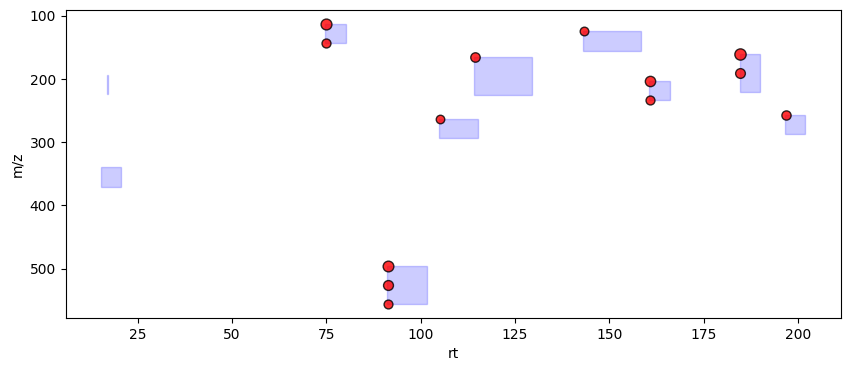

In [159]:
# do mid concentration 
fig, ax = plt.subplots(figsize=(10,4))
for f in sel_posFIDs:
    if f not in unwanted:
        for k,v in fid2khipu[f].feature_map.items(): # get other ions in the same khipu
            if v[0] in ['M0', '13C/12C', '13C/12C*2'] and v[1] in ['M+H+', 'Na/H', 'K/H', 'ACN']:
                rt = featureDict[f]['rtime'] + adduct_shift.get(v[1])
                mz = featureDict[f]['mz'] + iso_shift.get(v[0], 0) -1.0078  # use f to calculate m/z coordinate
                # intensity = featureDict[k]['representative_intensity'] # 
                intensity = fdata[sample_64][k]
                ax.plot(rt, mz, markersize=sz(intensity), marker='o', color='r', markeredgecolor='k', alpha=0.8)
        (LL, hlen, vlen) = dict_rect[f]
        rect = Rectangle(LL, hlen, vlen, 
                            linewidth=1, edgecolor='b', facecolor='b', alpha=0.2)
        ax.add_patch(rect)
        
ax.set_xlabel('rt')
ax.invert_yaxis()
ax.set_ylabel('m/z')
plt.savefig('mid_dilution_series_hilicpos.pdf', dpi=300)

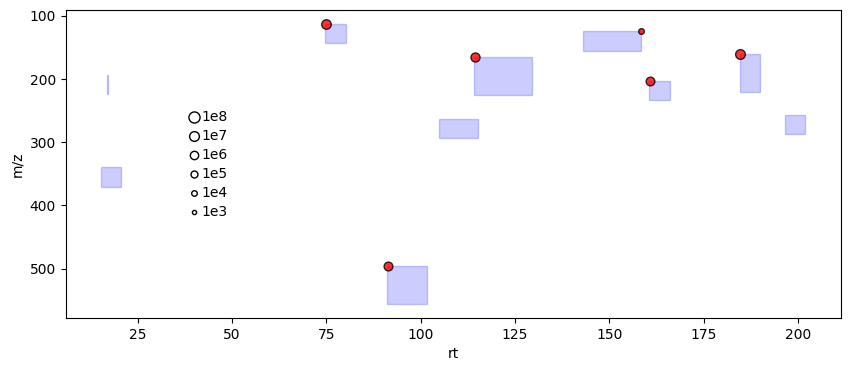

In [158]:
# do low concentration 
fig, ax = plt.subplots(figsize=(10,4))
for f in sel_posFIDs:
    if f not in unwanted:
        for k,v in fid2khipu[f].feature_map.items(): # get other ions in the same khipu
            if v[0] in ['M0', '13C/12C', '13C/12C*2'] and v[1] in ['M+H+', 'Na/H', 'K/H', 'ACN']:
                rt = featureDict[f]['rtime'] + adduct_shift.get(v[1])
                mz = featureDict[f]['mz'] + iso_shift.get(v[0], 0) -1.0078  # use f to calculate m/z coordinate
                # intensity = featureDict[k]['representative_intensity'] # 
                intensity = fdata[sample_1024][k]
                ax.plot(rt, mz, markersize=sz(intensity), marker='o', color='r', markeredgecolor='k', alpha=0.8)
                
        (LL, hlen, vlen) = dict_rect[f]
        rect = Rectangle(LL, hlen, vlen, 
                            linewidth=1, edgecolor='b', facecolor='b', alpha=0.2)
        ax.add_patch(rect)
        
# plot legend
for inten in [1000, 1e4, 1e5, 1e6, 1e7, 1e8]:
    Linten = np.log10(inten)
    ax.plot(40, 500 - 30*Linten, markersize=sz(inten), marker='o', color='w', markeredgecolor='k')
    ax.text(42, 500 - 30*Linten, '1e'+str(int(Linten)), verticalalignment='center')

ax.set_xlabel('rt')
ax.invert_yaxis()
ax.set_ylabel('m/z')
plt.savefig('low_dilution_series_hilicpos.pdf', dpi=300)

# Conclusion

Got illustrations to make Figure 1.